## **Weather Data Analysis**

In this step we are going to explore relationships between weather conditions and bikers activity, such as:

* Number of riders with respect to average temperature.
* Effect of precipitation and average temperature on the number of riders and the average duration of their trip.
* Linear regression of number of bikers with respect to increase in average temperature.

In [1]:
# import required packages
from os.path import abspath
import pandas as pd
import numpy as np

import plotnine.options as ggplot_options

from scipy.stats import linregress
from plotnine import (ggplot, aes, xlab, ylab, ggtitle, geom_line,
                      facet_wrap, scale_color_discrete, geom_point, geom_smooth)

# import utilities
from utilities.plot_utilities import plot_bikers_count_by_temp
from utilities.aggregation_utilities import (get_average_durations_and_counts,
                                             get_bike_counts_by_avg_temperature)

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.


#### **Loading and combining our datasets**

In [2]:
# filename constants
BIKES_FILENAME = "../data/processed/bikes_2016_02.csv"
WEATHER_FILENAME = "../data/processed/weather_2016_02.csv"

# column constants
TEMPERATURE_COLS = ['minimum temperature', 'maximum temperature', 'average temperature']
WEATHER_COLS = ['precipitation', 'snow fall', 'snow depth']

# load our datasets
bikes_df = pd.read_csv(abspath(BIKES_FILENAME))
weather_df = pd.read_csv(abspath(WEATHER_FILENAME))

# cast bikes dates correct types
bikes_df['starttime'] = pd.to_datetime(bikes_df['starttime'])
bikes_df['stoptime'] = pd.to_datetime(bikes_df['stoptime'])
weather_df['date'] = pd.to_datetime(weather_df['date'])

# attach whether its weekday or weekend
bikes_df['day_type'] = np.where(bikes_df['starttime'].dt.weekday < 5, 'Weekday', 'Weekend')

# transform temperatures from Fahrenheit to Celsius
weather_df[TEMPERATURE_COLS] = weather_df[TEMPERATURE_COLS].apply(lambda x: (x - 32) * 5/9)
weather_df[WEATHER_COLS] = weather_df[WEATHER_COLS].replace({'T': 0}).astype(float)

# join our two datasets
weatherly_bikes_df = pd.merge(left=bikes_df, right=weather_df, left_on='day', right_on='day')

### **Number of riders with respect to average temperature**

One thing we can explore is the number of bikers we have for different average temperature ranges. A problem with that would be that if a temperature range is more frequent during the month, we would be mislead that the particular temperature range is more desirable for riderships.

One way we can fix that is by normalizing the data with respect to the number of days the particular temperature range has occured during the month.

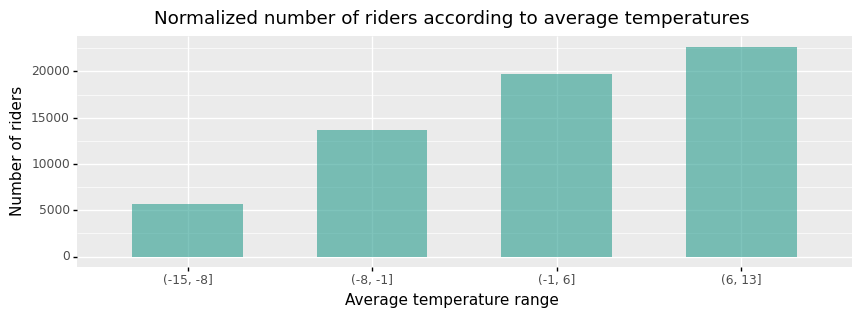

<ggplot: (324584123)>

In [3]:
ggplot_options.figure_size = (10, 3)

# plot normalized number of bikers w.r.t. different temperature ranges
(plot_bikers_count_by_temp(weatherly_bikes_df, weather_df, field='average temperature', nbins=5, barwidth=0.6) +
    ggtitle("Normalized number of riders according to average temperatures") +
    xlab("Average temperature range") +
    ylab("Number of riders")
)

We can see that with increase of the temperature, naturally a higher number of rides occur.

### **Effect of precipitation and average temperature on the number of riders and the average duration of their trip**

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


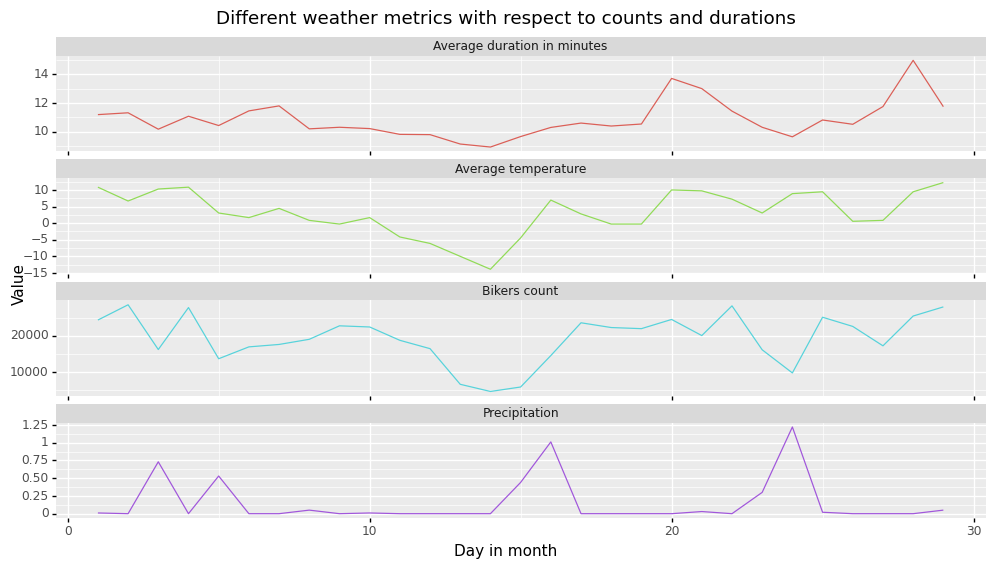

<ggplot: (326749925)>

In [17]:
ggplot_options.figure_size = (12, 6)
counts_and_avg_durations = get_average_durations_and_counts(weatherly_bikes_df)

METRIC_COLS = ["day", "average temperature", "precipitation"]

# join with humidity, snowfall, snow depth, temperature
(pd.merge(
    counts_and_avg_durations,
    weather_df[METRIC_COLS],
    left_on='day',
    right_on='day'
)
# titlelize column names for better visualization
.rename(columns=lambda word: ' '.join(x.capitalize() or '_' for x in word.split('_')))
# stack the dataframe
.melt(id_vars='Day')
# plot with different facets for different metrics
.pipe(ggplot) +
    aes(x='Day', y='value', color='variable') +
    geom_line() +
    facet_wrap('variable', scales='free', nrow=8) +
    ggtitle("Different weather metrics with respect to counts and durations") +
    xlab("Day in month") +
    ylab("Value") +
    scale_color_discrete(guide=False)
)

# counts_and_avg_durations

Naturally, we can see that with dropping in temperatures and precipitation increase, we get a drastic decrease in the number of bikers and their median trip duration. One interpretation for that might be that, when the weather is bad, people substitute their means of transportation - e.g. they might be using a bus instead of a bike.

### **Linear regression of number of bikers with respect to increase in average temperature**

Another thing we can do is apply a simple linear regression, expressing the number of bikers with respect to average temperature. Doing that we can see whether there's an upward trend, as well as calculate how many bikers on average we get with one degree change in temperature.

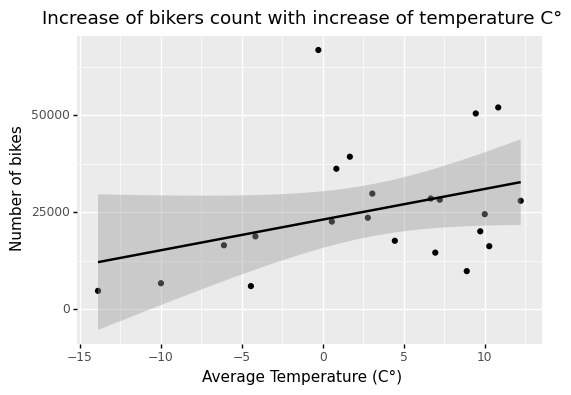

<ggplot: (324850734)>

In [5]:
ggplot_options.figure_size = (6, 4)

# aggregate the dataframe 
counts_temp_df = get_bike_counts_by_avg_temperature(weatherly_bikes_df)

lm = linregress(counts_temp_df['average temperature'], counts_temp_df['bikes_count'])

pval = lm.pvalue
slope = lm.slope

(counts_temp_df
 .pipe(ggplot) +
    aes(x='average temperature', y='bikes_count') +
    geom_point() +
    geom_smooth(method='lm') +
    xlab("Average Temperature (C°)") +
    ylab("Number of bikes") +
    ggtitle("Increase of bikers count with increase of temperature C°")
)

We are seeing a slope of approximately 792 units, which can be interpreted as gaining 792 more bikers on average with one degree increase in temperature. Our pvalue in this case is 0.099, with which we can consider the slope as statistically significant for a significance level $\alpha=0.10$, but not with $\alpha=0.05$. In this case, in 10% of the cases we might be erroneously considering the slope as significant when it is in fact not significant.